# Bat Player

In [1]:
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import librosa
import os
import copy

from scipy.signal import butter, sosfilt, spectrogram
from scipy.signal import resample
from IPython.display import Audio
import noisereduce as nr

In [31]:
def slowDown(audio_path, factor = 75):

    data, samplerate = sf.read(audio_path)
    new_samplerate = samplerate // factor
    slowed_data = data.copy()
    
    temp_path = audio_path[:-4]+'_temp.wav'
    sf.write(temp_path, slowed_data, new_samplerate)
    return slowed_data, temp_path

def lowFilter(audio_path, low_cut_freq = 100, order = 4):
    data, sample_rate = sf.read(audio_path)
    sos = butter(order, low_cut_freq, btype='highpass', fs=sample_rate, output='sos')
    filtered = sosfilt(sos, data)
    return filtered, sample_rate

def fadeIn(audio, sample_rate, duration = 0.3):
    length = int(duration*sample_rate)
    fade_curve = np.linspace(0.0, 1.0, length)
    new_audio = copy.deepcopy(audio)
    new_audio[:length] = new_audio[:length] * fade_curve
    return new_audio

def treatFile(audio_path, factor = 75, low_cut_freq = 100, order = 4):
    slowed_data, temp_path = slowDown(audio_path, factor)
    filtered, sample_rate = lowFilter(temp_path, low_cut_freq, order)
    os.remove(temp_path)
    reduced = nr.reduce_noise(y=filtered, sr=sample_rate, stationary=True, prop_decrease=0.75)
    faded = fadeIn(reduced, sample_rate)
    return faded, sample_rate
    
def writeTreatedFile(new_path, treated_data, sample_rate):
    sf.write(new_path, treated_data, sample_rate)
    return

def displayTreatedFile(filtered, sample_rate, factor, short):
    sr, data = sample_rate, filtered

    #only plot first minute at most
    if short:
        data = data[:sample_rate*60]

    nperseg = 2048
    noverlap = nperseg // 2
    frequencies, times, Sxx = spectrogram(data, fs=sr, nperseg=nperseg, noverlap=noverlap)

    Sxx_dB = 10 * np.log10(Sxx + 1e-10)

    # Plot spectrogram
    plt.figure(figsize=(12, 6))
    plt.pcolormesh(times, frequencies, Sxx_dB, shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title('Slowed Down Bat Calls — Factor '+str(factor))
    plt.colorbar(label='Intensity [dB]')
    plt.ylim(0, sr/2)
    plt.show()

def playTreatedFile(filtered, sample_rate, short):
    if short:
        filtered = filtered[:sample_rate * 60]
    return Audio(data=filtered, rate=sample_rate)
    

def batPlayer(audio_path, play = False, write = False, display = False, low_cut = 100, factor = 75, order = 4, short=False):

    filtered, sample_rate = treatFile(audio_path, factor, low_cut, order)

    new_path = audio_path[:-4] + '_audible.wav'

    if write:
        writeTreatedFile(new_path, filtered, sample_rate)

    if display:
        displayTreatedFile(filtered, sample_rate, factor, short)

    if play:
        return playTreatedFile(filtered, sample_rate, short)
    else:
        return 

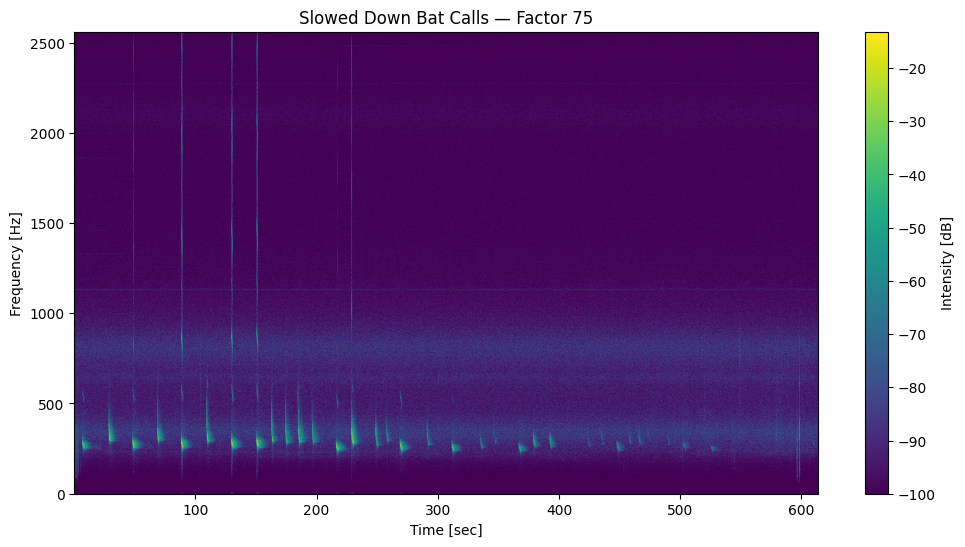

In [33]:
batPlayer('audio/noctule.wav', play = True, write = False, display = True, low_cut = 100, factor = 75, order = 4, short=False)